In [1]:
import os
import numpy as np
import torch
from torch import Tensor
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.nn.functional as F

from lib.parts_dataset import PartsDataset,DatasetSplit
from lib.parts_model import PartsModel
from lib.opt import optimize

import lib.media as media
from IPython.display import Audio
from scipy.io import wavfile

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'
#os.environ['CUDA_LAUNCH_BLOCKING']='1'

checkpoint_dir = '_singlepart1'
context = 1

In [3]:
train_set = PartsDataset(context=context,split=DatasetSplit.train)
test_set = PartsDataset(context=context,split=DatasetSplit.test)

Found cached parts datafile at data/parts_data.npz (7271 parts)
Found cached parts datafile at data/parts_data.npz (7271 parts)


In [4]:
class Model(PartsModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def define_graph(self, debug=False):
        self.maxdur = train_set.maxdur
        
        self.note_mask = Variable(torch.from_numpy(np.tril(np.ones([self.m,self.m],dtype=np.float32),k=-1)).cuda(),requires_grad=False)
        
        # rhythm prediction
        self.rhythm_bias = Parameter(Tensor(self.maxdur))
        
        # notes prediction
        self.notes_bias = Parameter(Tensor(self.m))
    
    def predict_rhythm(self, e, t):
        return self.rhythm_bias[None,:].expand(e.shape[0],-1)
    
    def predict_notes(self, e, t, y, yt):
        return self.notes_bias[None,:].expand(e.shape[0],-1)
    
    def forward(self, x):
        e,t,y,yt,loc = x
        return self.predict_rhythm(e,t), self.predict_notes(e,t,y,yt)

In [5]:
model = Model(checkpoint_dir, avg=.999, context_length=context,
              offset=train_set.offset, m=train_set.m, dur_map=train_set.dur_map,
              weight_scale=0)
model.initialize()

rhythm_bias torch.Size([34]) (34)
notes_bias torch.Size([78]) (78)
Initialized graph with 112 parameters


In [ ]:
optimize(model,train_set,test_set,learning_rate=.01,batch_size=300,workers=4,update_rate=1000)

Initiating optimizer, 6710 iterations/epoch.
acct_tr	acct_ts	apn_tr	apn_ts	iter	ll_test	ll_tr	lln_ts	llt_ts	time	utime
37.04   36.60   4.92    4.72    1000    15.12   15.10   11.78   3.35    18.81   18.13   
37.05   36.61   4.92    4.72    2000    11.04   11.01   8.03    3.01    97.96   19.12   
37.04   36.60   4.92    4.72    3000    10.28   10.23   7.34    2.94    99.95   19.02   
37.03   36.59   4.92    4.72    4000    10.14   10.09   7.22    2.92    97.60   18.96   
37.04   36.60   4.92    4.72    5000    10.11   10.05   7.19    2.92    96.88   17.53   
36.99   36.59   4.92    4.72    6000    10.09   10.03   7.18    2.92    96.32   17.47   
37.03   36.59   4.92    4.72    7000    10.09   10.02   7.17    2.92    98.13   18.23   
37.02   36.58   4.92    4.72    7710    10.08   10.02   7.17    2.92    72.24   16.80   
37.01   36.59   4.92    4.71    8710    10.08   10.02   7.17    2.91    97.13   18.13   
37.00   36.60   4.92    4.72    9710    10.08   10.01   7.17    2.91    97.27   

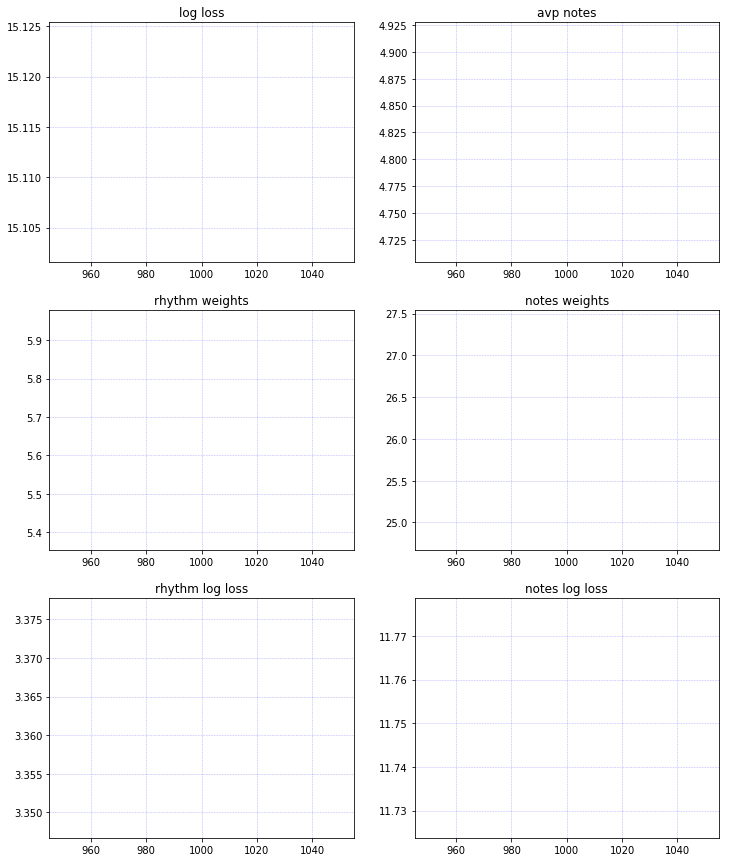

In [7]:
model.restore_checkpoint()
plt = media.PlotFormatter()
plt.plot('log loss',model.stats['ll_tr'][2],color='b')
plt.plot('log loss',model.stats['ll_test'][2],color='g',share=True)
plt.plot('avp notes',model.stats['apn_tr'][2],color='b')
plt.plot('avp notes',model.stats['apn_ts'][2],color='g',share=True)
plt.plot('rhythm weights',model.sum_weights('rhythm'),color='g')
plt.plot('notes weights',model.sum_weights('notes'),color='g')
plt.plot('rhythm log loss',model.stats['llt_tr'][2],color='b')
plt.plot('rhythm log loss',model.stats['llt_ts'][2],color='g',share=True)
plt.plot('notes log loss',model.stats['lln_tr'][2],color='b')
plt.plot('notes log loss',model.stats['lln_ts'][2],color='g',share=True)
plt.show()